In [1]:
%run init_notebookspace.py
from settings import *

In [2]:
%matplotlib inline
import gEconpy as ge
import gEconpy.plotting as gp

import matplotlib.pyplot as plt

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def compare_steady_states(models, names):
    all_keys = set()
    for model in models:
        all_keys = all_keys.union(set(list(model.steady_state_dict.keys())))
    
    header = ' ' * 10 + ''.join([f'{name:>10}' for name in names])
    print(header)
    print('-' * len(header))

    for key in all_keys:
        line = f'{key:<10}'
        for model in models:
            if key in model.steady_state_dict.keys():
                value = f'{model.steady_state_dict[key]:>10.3f}'
            else:
                value = f'{"---":>10}'
            line += value 
        print(line)

# Table of contents

# Basic RBC

In [4]:
rbc_base = ge.gEconModel(os.path.join(DATA_DIR, "rbc_basic.gnc"))

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [5]:
rbc_base.steady_state()
rbc_base.solve_model()
rbc_base.print_steady_state()

print('\nBlanchard Kahn Conditions')
rbc_base.check_bk_condition();

Steady state found! Sum of squared residuals is 1.47501368398038e-19
Solution found, sum of squared residuals:  4.0781870427091863e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
A_ss               1.000
C_ss               6.790
I_ss               1.018
K_ss             101.771
L_ss               3.138
Y_ss               7.808
lambda_ss          0.987
r_ss               0.020
w_ss               1.836

Blanchard Kahn Conditions
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


## Impulse Response function

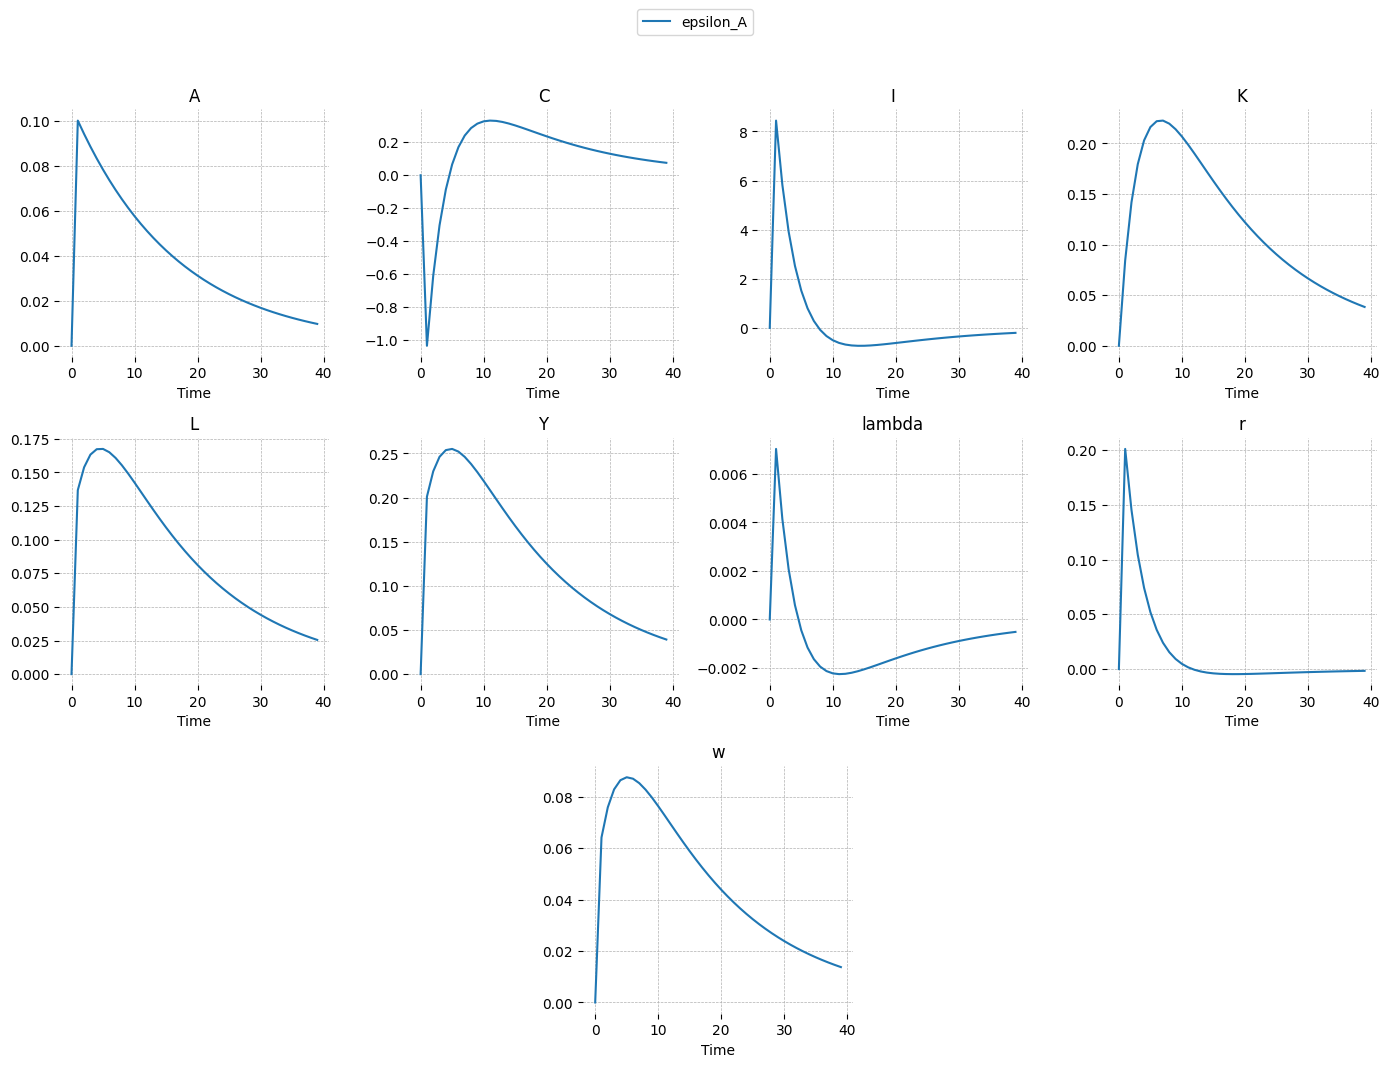

In [6]:
base_irf = rbc_base.impulse_response_function(simulation_length=40, shock_size=.1)
gp.plot_irf(base_irf, legend=True);

Why is the cov on I so high?

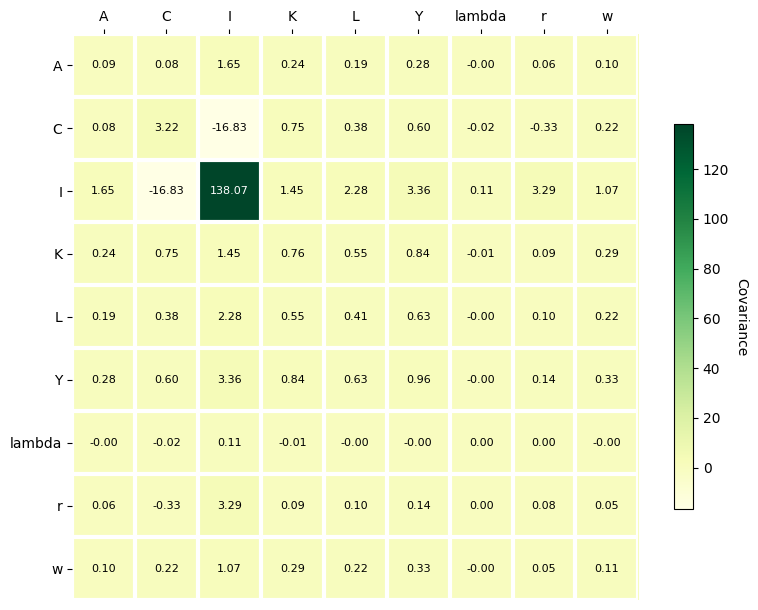

In [7]:
gp.plot_covariance_matrix(rbc_base.compute_stationary_covariance_matrix(), cbar_kw={'shrink': 0.5});

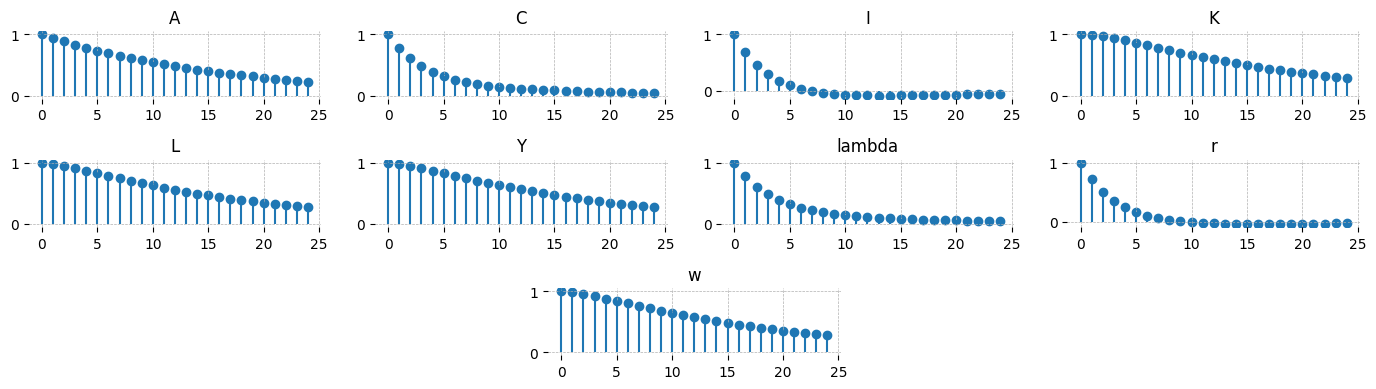

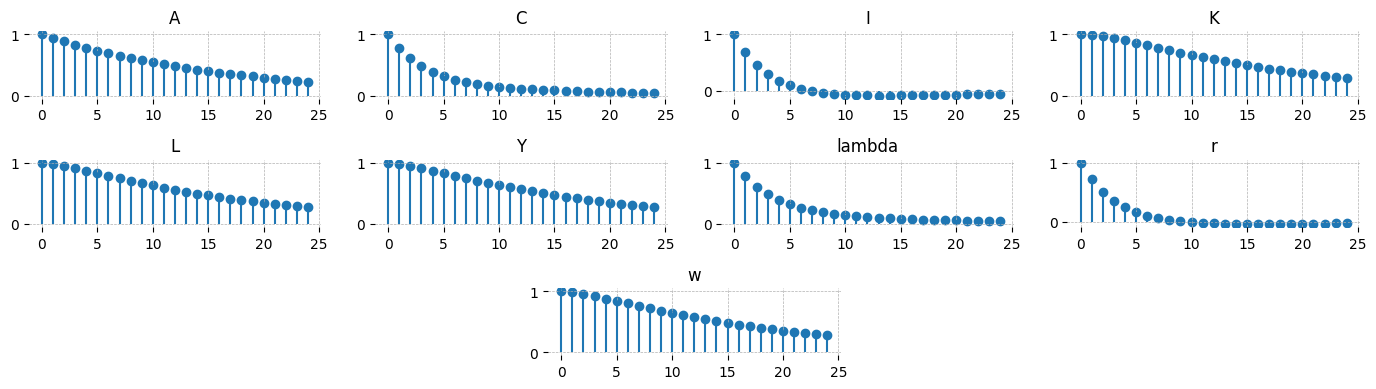

In [8]:
gp.plot_acf(rbc_base.compute_autocorrelation_matrix(n_lags=25))

# Capital Adjustment Cost

In [9]:
rbc_capadj = ge.gEconModel(os.path.join(DATA_DIR, "rbc_capadj.gnc"))

Model Building Complete.
Found:
	11 equations
	11 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	7 parameters
		 4 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [10]:
rbc_capadj.steady_state()
rbc_capadj.solve_model()
print('\nSteady State')
rbc_capadj.print_steady_state()

print('\n\nBlanchard Kahn Conditions')
rbc_capadj.check_bk_condition();

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  1.831805550351403e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000

Steady State
A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Q_ss               1.000
Y_ss               3.073
lambda_ss          0.276
q_ss               0.276
r_ss               0.030
w_ss               2.436


Blanchard Kahn Conditions
Model solution has 4 eigenvalues greater than one in modulus and 4 forward-looking variables.
Blanchard-Kahn condition is satisfied.


## Impulse Response function

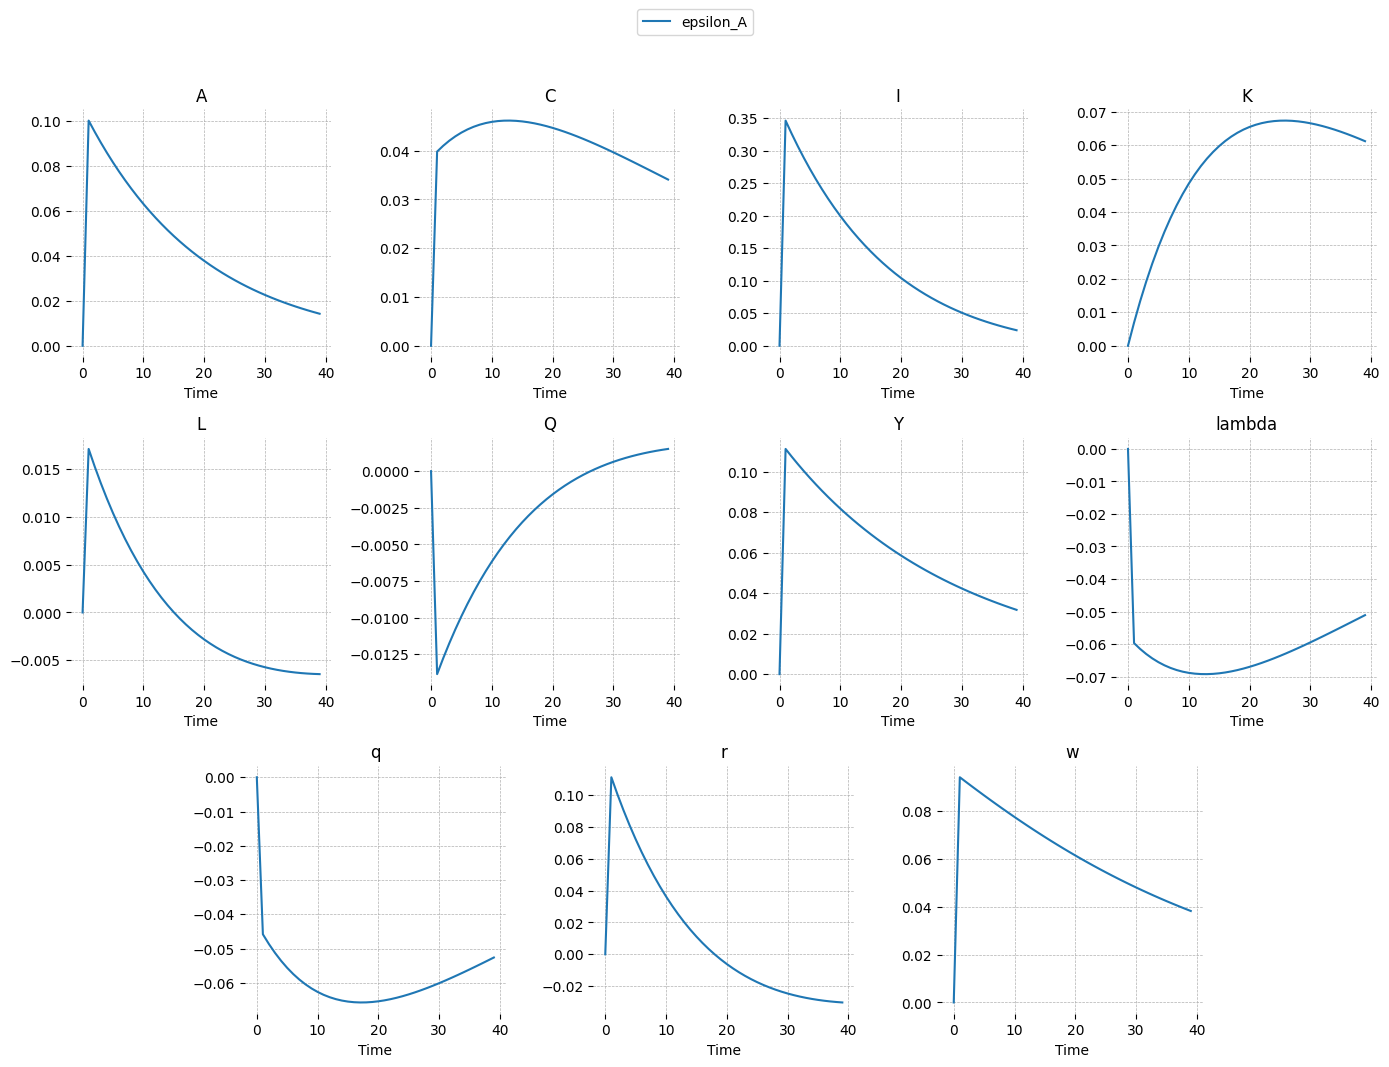

In [11]:
capajd_irf = rbc_capadj.impulse_response_function(simulation_length=40, shock_size=.1)
gp.plot_irf(capajd_irf, legend=True);

Why is the cov on I so high?

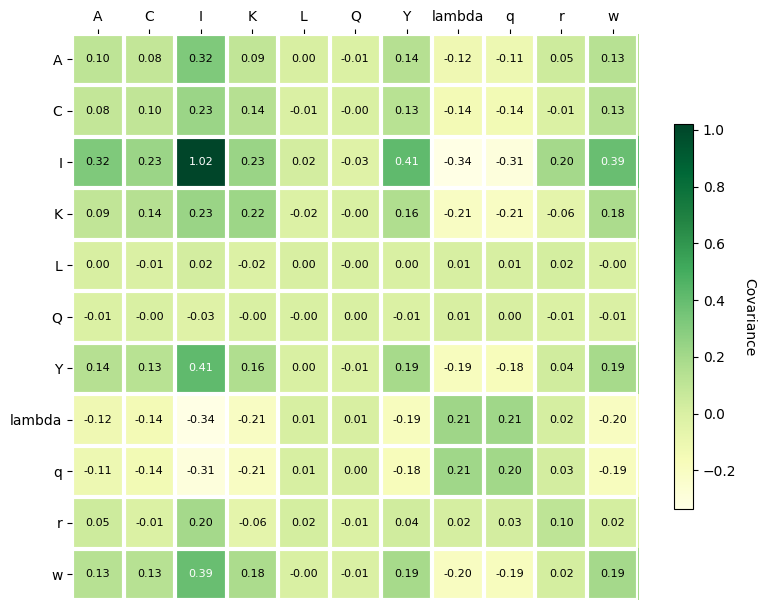

In [12]:
gp.plot_covariance_matrix(rbc_capadj.compute_stationary_covariance_matrix(), cbar_kw={'shrink': 0.5});

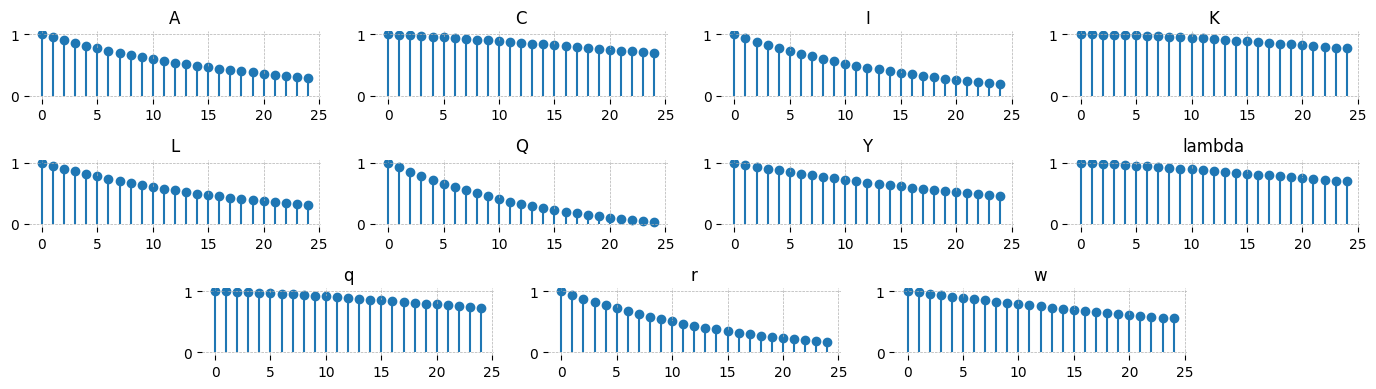

In [13]:
gp.plot_acf(rbc_capadj.compute_autocorrelation_matrix(n_lags=25));

# Compare Steady states

In [15]:
compare_steady_states([rbc_base, rbc_capadj], ['Baseline', 'K Adj'])

            Baseline     K Adj
------------------------------
A_ss           1.000     1.000
lambda_ss      0.987     0.276
Y_ss           7.808     3.073
L_ss           3.138     0.820
I_ss           1.018     0.715
K_ss         101.771    35.732
q_ss             ---     0.276
C_ss           6.790     2.358
w_ss           1.836     2.436
Q_ss             ---     1.000
r_ss           0.020     0.030
